<a href="https://colab.research.google.com/github/ViniciusLabruna/previsao-teus-cabotagem/blob/main/A3_Vers%C3%A3o_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão de Volume de TEUs para Cabotagem no Brasil em 2025



# 1.INTRODUÇÃO

1.1 O que é Cabotagem?

Cabotagem é o transporte marítimo de cargas realizado entre portos de um mesmo país. No Brasil, essa modalidade é muito utilizada devido à extensa costa, sendo uma alternativa ao transporte rodoviário. A cabotagem é mais sustentável e econômica para grandes volumes de carga.
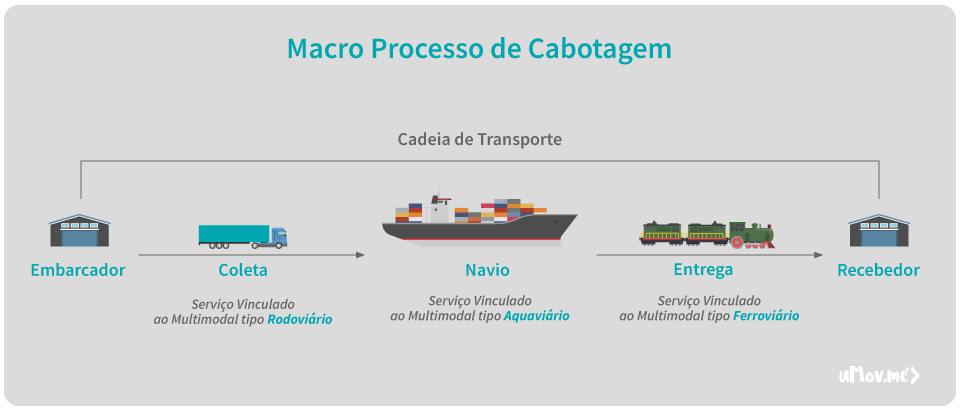
<br>
1.2 O que é TEU?<br>
TEU (Twenty-foot Equivalent Unit) é uma unidade de medida padrão no transporte marítimo, usada para descrever a capacidade de um contêiner ou o volume de carga transportado. Um TEU equivale ao tamanho de um contêiner de 20 pés.
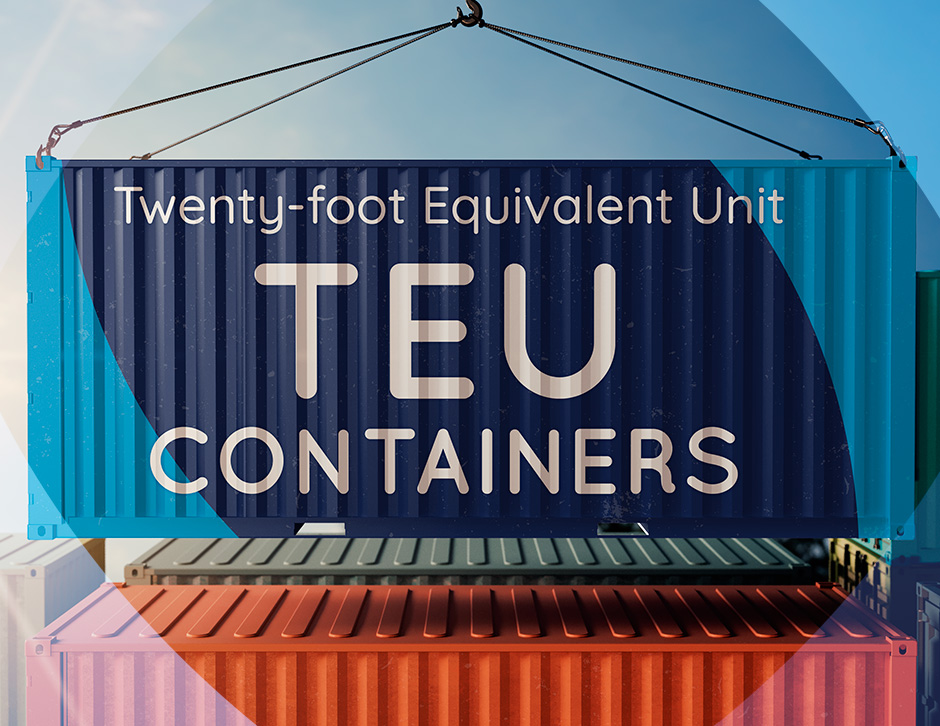


# 2. Explicação do Projeto

O objetivo do projeto é utilizar dados históricos de movimentação de cargas em cabotagem fornecidos pela ANTAQ (Agência Nacional de Transportes Aquaviários), de 2019 até Setembro de 2024, para prever a demanda de TEUs no Brasil em 2025.

Os dados foram processados, tratados e utilizados para construir uma previsão usando o modelo Prophet, que é especialmente adequado para séries temporais com padrões sazonais e tendências.

# 3. Modelo Prophet e sua Escolha

<p>
O Prophet, desenvolvido pelo Facebook, é uma ferramenta robusta para modelagem de séries temporais, ideal para lidar com padrões sazonais, tendências não lineares e lacunas nos dados. Ele se destaca por sua facilidade de uso, identificação automática de sazonalidades e geração de intervalos de confiança.
</p>

<p>
<strong>Foi escolhido para este projeto por:</strong>
</p>
<ul>
  <li><strong>Sazonalidade Anual:</strong> Captura flutuações ligadas a períodos econômicos e festivos.</li>
  <li><strong>Robustez:</strong> Lida bem com dados incompletos ou ruidosos.</li>
  <li><strong>Previsão de Longo Prazo:</strong> Adequado para projeções até 2025.</li>
  <li><strong>Facilidade de Implementação:</strong> Integra-se facilmente ao pipeline.</li>
</ul>

<p>
Apesar de supor que a sazonalidade passada persista no futuro, suas características o tornam ideal para prever volumes de TEUs na cabotagem, proporcionando análises confiáveis e de fácil interpretação.
</p>


**<h3>Importação de Dados e Pré-Processamento</h3>**

<p>
Carregamos os arquivos txt de 2019 até 2024, importados da ANTAQ, de Carga para saber a quantidade de TEU e o de Atracação para saber a Data de Atracação, por fim, filtramos apenas por essas duas colunas que serão utilizadas para a análise da previsão.
</p>


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

# Montar o Google Drive
drive.mount('/content/drive')

# Lista de arquivos de carga
carga_file_paths = [
    '/content/drive/MyDrive/Projeto A3 - Previsao de Demanda de Carga na Cabotagem/2019Carga.txt',
    '/content/drive/MyDrive/Projeto A3 - Previsao de Demanda de Carga na Cabotagem/2020Carga.txt',
    '/content/drive/MyDrive/Projeto A3 - Previsao de Demanda de Carga na Cabotagem/2021Carga.txt',
    '/content/drive/MyDrive/Projeto A3 - Previsao de Demanda de Carga na Cabotagem/2022Carga.txt',
    '/content/drive/MyDrive/Projeto A3 - Previsao de Demanda de Carga na Cabotagem/2023Carga.txt',
    '/content/drive/MyDrive/Projeto A3 - Previsao de Demanda de Carga na Cabotagem/2024Carga.txt'
]

# Carregar e concatenar os dados em uma única etapa
df_carga = pd.concat(
    (pd.read_csv(file, sep=';', encoding='utf-8', low_memory=False) for file in carga_file_paths),
    ignore_index=True
)

df_carga = df_carga[df_carga['Tipo Operação da Carga'] == 'Cabotagem']
df_carga = df_carga[['IDAtracacao', 'TEU']]

# Lista de arquivos de atracação
atracacao_file_paths = [
    '/content/drive/MyDrive/Projeto A3 - Previsao de Demanda de Carga na Cabotagem/2019Atracacao.txt',
    '/content/drive/MyDrive/Projeto A3 - Previsao de Demanda de Carga na Cabotagem/2020Atracacao.txt',
    '/content/drive/MyDrive/Projeto A3 - Previsao de Demanda de Carga na Cabotagem/2021Atracacao.txt',
    '/content/drive/MyDrive/Projeto A3 - Previsao de Demanda de Carga na Cabotagem/2022Atracacao.txt',
    '/content/drive/MyDrive/Projeto A3 - Previsao de Demanda de Carga na Cabotagem/2023Atracacao.txt',
    '/content/drive/MyDrive/Projeto A3 - Previsao de Demanda de Carga na Cabotagem/2024Atracacao.txt'
]

# Carregar e concatenar os dados em uma única etapa
df_atracacao = pd.concat(
    (pd.read_csv(file, sep=';', encoding='utf-8', low_memory=False) for file in atracacao_file_paths),
    ignore_index=True
)

df_atracacao = df_atracacao[['IDAtracacao', 'Data Atracação']]



Mounted at /content/drive



**<h3>Merge dos Dados</h3>**

<p>
Combinamos os dados de Carga e Atracação por meio da chave IDAtracacao.
</p>


In [ ]:
# Realizar o merge
df_cabotagem = pd.merge(
    df_carga,
    df_atracacao,
    on='IDAtracacao',  # Coluna para ligar os DataFrames
    how='inner'        # Tipo de junção (inner: apenas correspondências)
)


**<h3>Verificar Tipos de Dados</h3>**

<p>
Inspecionamos os tipos de dados antes de realizar conversões ou análises.
</p>


In [ ]:
df_cabotagem.dtypes

,0
IDAtracacao,int64
TEU,object
Data Atracação,object



**<h3>Limpeza e Conversão de Dados</h3>**

<p>
Garantimos que os dados estão no formato correto e que entradas inválidas sejam removidas. Também removendo alguns dados de final 2018 de estão presentes nos dados de 2019.
</p>


In [ ]:
# Convertendo 'TEU' para numérico, tratando erros
df_cabotagem['TEU'] = pd.to_numeric(df_cabotagem['TEU'], errors='coerce')

# Convertendo 'Data Atracação' para datetime, tratando erros
df_cabotagem['Data Atracação'] = pd.to_datetime(df_cabotagem['Data Atracação'], errors='coerce')

# Exibindo os tipos de dados após a conversão
print(df_cabotagem.dtypes)

# Removendo linhas com valores NaN após a conversão
df_cabotagem.dropna(subset=['TEU', 'Data Atracação'], inplace=True)

df_cabotagem = df_cabotagem.drop_duplicates()

df_cabotagem = df_cabotagem[df_cabotagem['Data Atracação'].dt.year >= 2019]



<ipython-input-5-50e8c745a27b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cabotagem['TEU'] = pd.to_numeric(df_cabotagem['TEU'], errors='coerce')
<ipython-input-5-50e8c745a27b>:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_cabotagem['Data Atracação'] = pd.to_datetime(df_cabotagem['Data Atracação'], errors='coerce')


IDAtracacao                int64
TEU                      float64
Data Atracação    datetime64[ns]
dtype: object


<h2>5. Visualização do Volume de TEUs e Previsões</h2>

<p>
Nesta célula, geramos gráficos que mostram a evolução do volume de TEUs ao longo do tempo (2019-2025), com destaque para os dados reais e as previsões feitas pelo modelo Prophet. A visualização é dividida em três partes:
</p>

<ul>
  <li><strong>Dados reais (2019-2024):</strong> Representados por uma linha azul com pontos, mostrando o histórico observado de TEUs.</li>
  <li><strong>Previsões (2024-2025):</strong>
    <ul>
      <li>Pontos pretos até setembro de 2024 indicam previsões do Prophet.</li>
      <li>Uma linha verde representa as previsões de outubro a dezembro de 2024.</li>
      <li>Uma linha laranja mostra as previsões para 2025.</li>
    </ul>
  </li>
  <li><strong>Intervalo de confiança:</strong> A área sombreada em azul claro reflete a incerteza das previsões para 2024-2025, ajudando a compreender a margem de erro.</li>
</ul>

<p>
Outras configurações importantes incluem limites no eixo Y para destacar os volumes de TEUs (entre 100.000 e 220.000) e ajustes nos rótulos dos eixos para melhorar a legibilidade. A visualização destaca a conexão entre os dados históricos e as previsões futuras, fornecendo uma visão clara da evolução projetada para o setor de cabotagem.
</p>


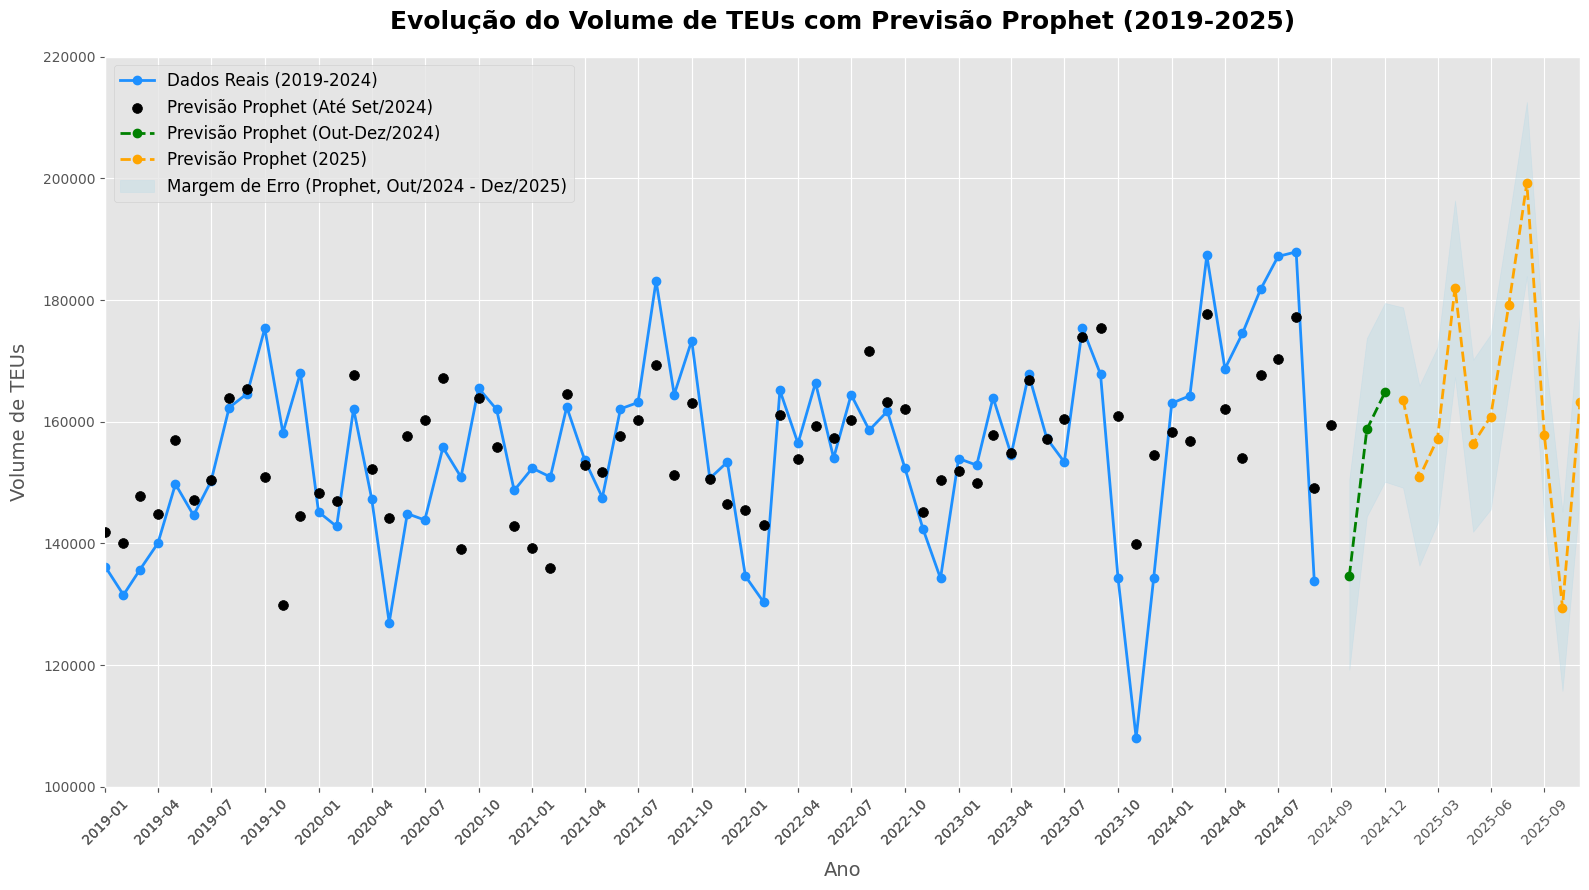

In [ ]:
#Configurar estilo do gráfico
plt.style.use('ggplot')

# Tamanho da figura
plt.figure(figsize=(16, 9))

# Adicionar dados reais com formatação elegante
plt.plot(
    monthly_teu.index,
    monthly_teu.values,
    marker='o',
    linestyle='-',
    linewidth=2.0,
    color='dodgerblue',
    label='Dados Reais (2019-2024)'
)

# 6. Separar previsões e intervalos de confiança
forecast_filtered = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_filtered.set_index('ds', inplace=True)

# Previsões Prophet - bolinhas pretas até setembro de 2024
forecast_to_sep = forecast_filtered.loc[:'2024-09-30']
plt.scatter(
    forecast_to_sep.index,
    forecast_to_sep['yhat'],
    color='black',
    label='Previsão Prophet (Até Set/2024)',
    zorder=3,
    s=50  # Tamanho das bolinhas
)

# Previsões Prophet - linha verde de outubro a dezembro de 2024
forecast_oct_to_dec = forecast_filtered.loc['2024-10-01':'2024-12-31']
plt.plot(
    forecast_oct_to_dec.index,
    forecast_oct_to_dec['yhat'],
    marker='o',
    linestyle='--',
    linewidth=2.0,
    color='green',
    label='Previsão Prophet (Out-Dez/2024)'
)

# Previsões Prophet - bolinha e linha laranja após dezembro de 2024
forecast_post_dec = forecast_filtered.loc['2025-01-01':]
plt.plot(
    forecast_post_dec.index,
    forecast_post_dec['yhat'],
    marker='o',
    linestyle='--',
    linewidth=2.0,
    color='orange',
    label='Previsão Prophet (2025)'
)

# Margem de erro apenas de outubro de 2024 a dezembro de 2025
forecast_with_ci = forecast_filtered.loc['2024-10-01':'2025-12-31']
plt.fill_between(
    forecast_with_ci.index,
    forecast_with_ci['yhat_lower'],
    forecast_with_ci['yhat_upper'],
    color='lightblue',
    alpha=0.3,
    label='Margem de Erro (Prophet, Out/2024 - Dez/2025)'
)

# Verificar se existe gap entre setembro de 2024 e outubro de 2024
# Caso exista, vamos preencher esse gap
if '2024-10-01' in forecast_filtered.index:
    plt.plot(
        ['2024-09-30', '2024-10-01'],  # Garantir que setembro se conecte a outubro
        [monthly_teu.loc['2024-09-01':'2024-09-30'].values[-1], forecast_filtered.loc['2024-10-01']['yhat']],
        linestyle='-',
        color='dodgerblue',
        linewidth=2.0,
        zorder=1
    )

# Configurações do gráfico
plt.title('Evolução do Volume de TEUs com Previsão Prophet (2019-2025)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Ano', fontsize=14, labelpad=10)
plt.ylabel('Volume de TEUs', fontsize=14, labelpad=10)

# Legenda
plt.legend(fontsize=12, loc='upper left', frameon=True)

# Limites para os eixos
plt.xlim(combined_data.index.min(), combined_data.index.max())
plt.ylim(100000, 220000)  # Limitar o eixo Y entre 100.000 e 250.000

# Rótulos do eixo X
plt.xticks(
    combined_data.index[::3],  # Rótulos a cada 3 meses
    [f"{date.year}-{date.month:02d}" for date in combined_data.index[::3]],
    rotation=45,
    fontsize=10
)

# Rótulos do eixo Y
plt.yticks(fontsize=10)

# Exibir gráfico
plt.tight_layout()
plt.show()

<h2>Conclusão</h2>

<p>
Este projeto teve como objetivo acadêmico explorar a previsão do volume de TEUs na cabotagem no Brasil em 2025, utilizando apenas dados históricos disponibilizados pela ANTAQ. Através da análise sazonal e da aplicação do modelo Prophet, foi possível identificar padrões históricos de volume que refletem a dinâmica do setor ao longo dos anos.
</p>

<p>
As previsões geradas consideram a sazonalidade dos dados, mas é importante ressaltar que o modelo não leva em conta fatores externos como variações econômicas, mudanças políticas, climáticas ou outras variáveis exógenas que podem impactar significativamente as operações de cabotagem.
</p>

<p>
Embora os resultados ofereçam uma boa base para análise, reforça-se que as projeções são baseadas em tendências passadas e não devem ser interpretadas como garantias de comportamento futuro. Este projeto destaca o potencial das técnicas de machine learning e análise de séries temporais no estudo acadêmico de setores logísticos, ao mesmo tempo em que evidencia a importância de considerar variáveis externas para uma análise mais completa em estudos futuros.
</p>
